In [1]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt # diagra/figure
%matplotlib inline

In [8]:
words = open('names.txt', 'r').read().splitlines()
words[0:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [23]:
len(words)

32033

In [22]:
# build the vocabulary of character and mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [139]:
# build the dataset

block_size = 3 # contest length: how many character do we take to predict to the next one
X, Y = [], []

for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append
X = torch.tensor(X)
Y = torch.tensor(Y)

In [251]:
# build the dataset
# for training/dev/test set separately 
# training split, dev/validation split, test split
# 80%, 10%, 10%

block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [140]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [141]:
C = torch.randn(27, 2)

In [142]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [143]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [144]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # view() operation - '-1' means pytorch infer what it should be

In [145]:
h.shape

torch.Size([228146, 100])

In [146]:
h

tensor([[-0.9993, -0.9711, -1.0000,  ...,  0.8791,  0.1223,  0.9826],
        [-0.9977, -0.9999, -1.0000,  ...,  0.9452,  0.8425,  0.9537],
        [-0.8696, -0.9968, -0.6929,  ...,  0.9996, -0.4152,  0.9885],
        ...,
        [-0.9883, -0.9736, -0.9327,  ...,  0.7405,  0.6909,  0.9333],
        [ 0.0354,  0.1472,  0.6592,  ...,  0.9654, -0.8936,  0.6249],
        [-0.9848, -0.4804, -0.9478,  ..., -0.8090,  0.5491,  0.8764]])

In [147]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [148]:
logits = h @ W2 + b2

In [149]:
logits.shape

torch.Size([228146, 27])

In [150]:
counts = logits.exp()

In [151]:
prob = counts / counts.sum(1, keepdims=True)

In [152]:
prob.shape

torch.Size([228146, 27])

In [153]:
torch.arange(32)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [154]:
Y

tensor([ 5, 13, 13,  ..., 26, 24,  0])

In [114]:
# -------------------------------------------------------

In [306]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [307]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g)
b1= torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [308]:
sum(p.nelement () for p in parameters) # number of parameters

10281

In [309]:
for p in parameters:
    p.requires_grad = True

In [286]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [310]:
lri = []
lossi = []
stepi = []

for i in range(30000):
    
    # minibatch for fast implementation
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass 
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 #(32, 27)
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = - prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    #lr = lrs[i]
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad
        
    # track
    #lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.item())
    

#print(loss.item())

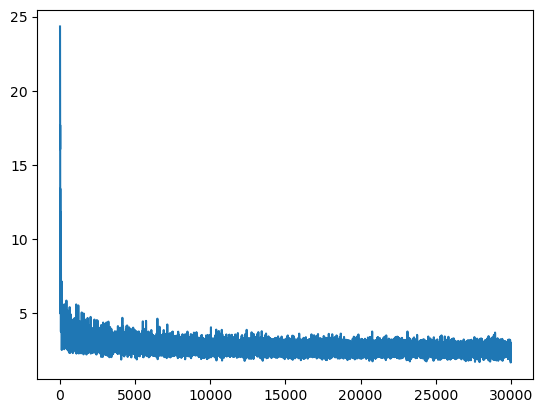

In [311]:
plt.plot(stepi, lossi)

In [312]:
# while training and dev are almost equal we are not overfiting 
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 #(32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.4392, grad_fn=<NllLossBackward0>)

In [313]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 #(32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.4392, grad_fn=<NllLossBackward0>)